In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [21]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')

In [22]:
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [23]:
df.tail()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


In [24]:
df.columns = ['Month', 'Milk_produced']

In [25]:
df.tail()

,Month,Milk_produced
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


In [26]:
df = df.drop(index=168, axis=0)

In [28]:
df['Month'] = pd.to_datetime(df['Month'])

In [29]:
df.set_index('Month', inplace=True)

In [30]:
df.tail()

,Milk_produced
Month,
1975-08-01,858.0
1975-09-01,817.0
1975-10-01,827.0
1975-11-01,797.0
1975-12-01,843.0


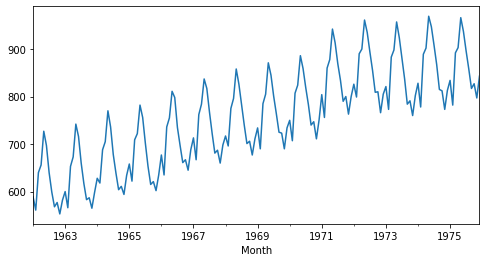

In [31]:
plt.figure(figsize=(8, 4))
df['Milk_produced'].plot()

In [32]:
df.describe()

,Milk_produced
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


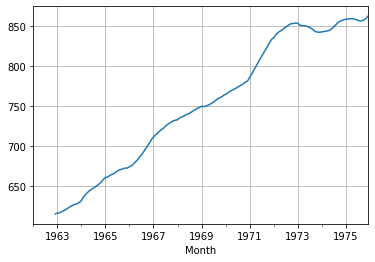

In [39]:
df['Milk_produced'].rolling(12).mean().plot(label='12 month rolling mean')
plt.grid()

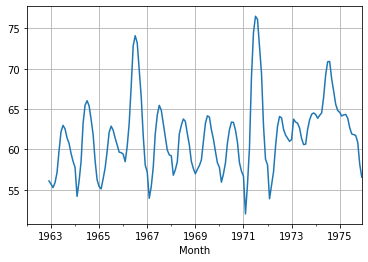

In [41]:
df['Milk_produced'].rolling(12).std().plot(label='12 month rolling std')
plt.grid()

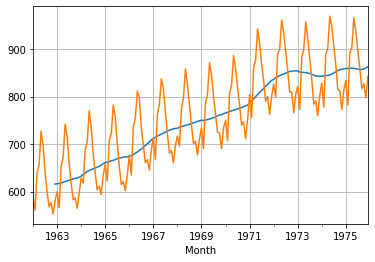

In [42]:
df['Milk_produced'].rolling(12).mean().plot(label='12 month rolling mean')
df['Milk_produced'].plot()
plt.grid()

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [46]:
decomposition = seasonal_decompose(df['Milk_produced'], freq=12)

<Figure size 432x288 with 0 Axes>

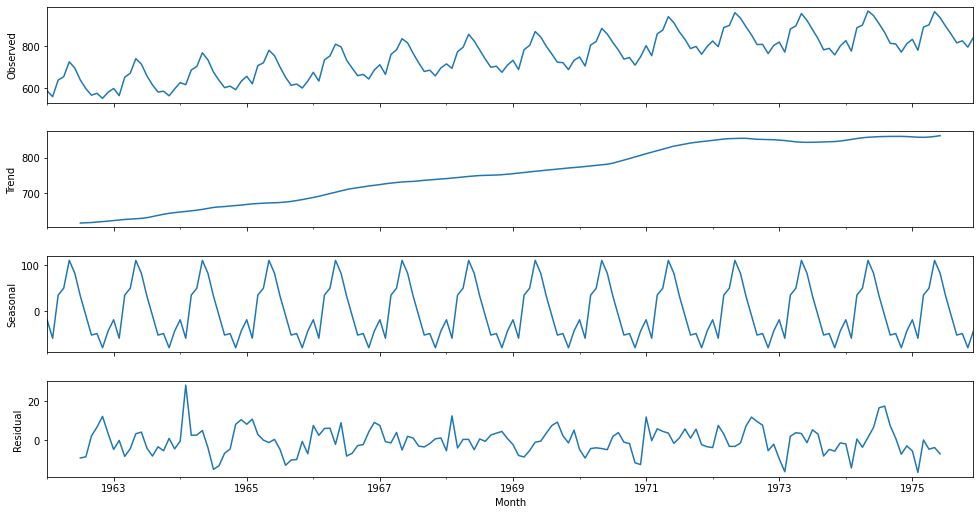

In [50]:
fig = plt.figure()  
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [53]:
from statsmodels.tsa.stattools import adfuller

In [54]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic',
              'p-value',
              '#Lags Used',
              'Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [55]:
adf_check(df['Milk_produced'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.3038115874221246
p-value : 0.627426708603034
#Lags Used : 13
Number of Observations Used : 154
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


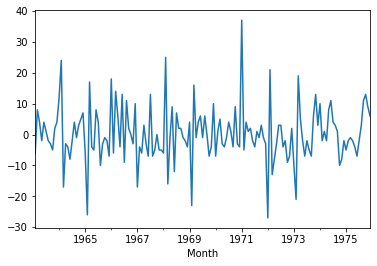

In [56]:
#Differencing
seasonal_differencing = df['Milk_produced'] - df['Milk_produced'].shift(12)
trend_differencing = seasonal_differencing - seasonal_differencing.shift(1)
trend_seasonality_removed = trend_differencing.dropna()
trend_seasonality_removed.plot()

In [57]:
adf_check(trend_seasonality_removed)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.038002274921979
p-value : 1.865423431878876e-05
#Lags Used : 11
Number of Observations Used : 143
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


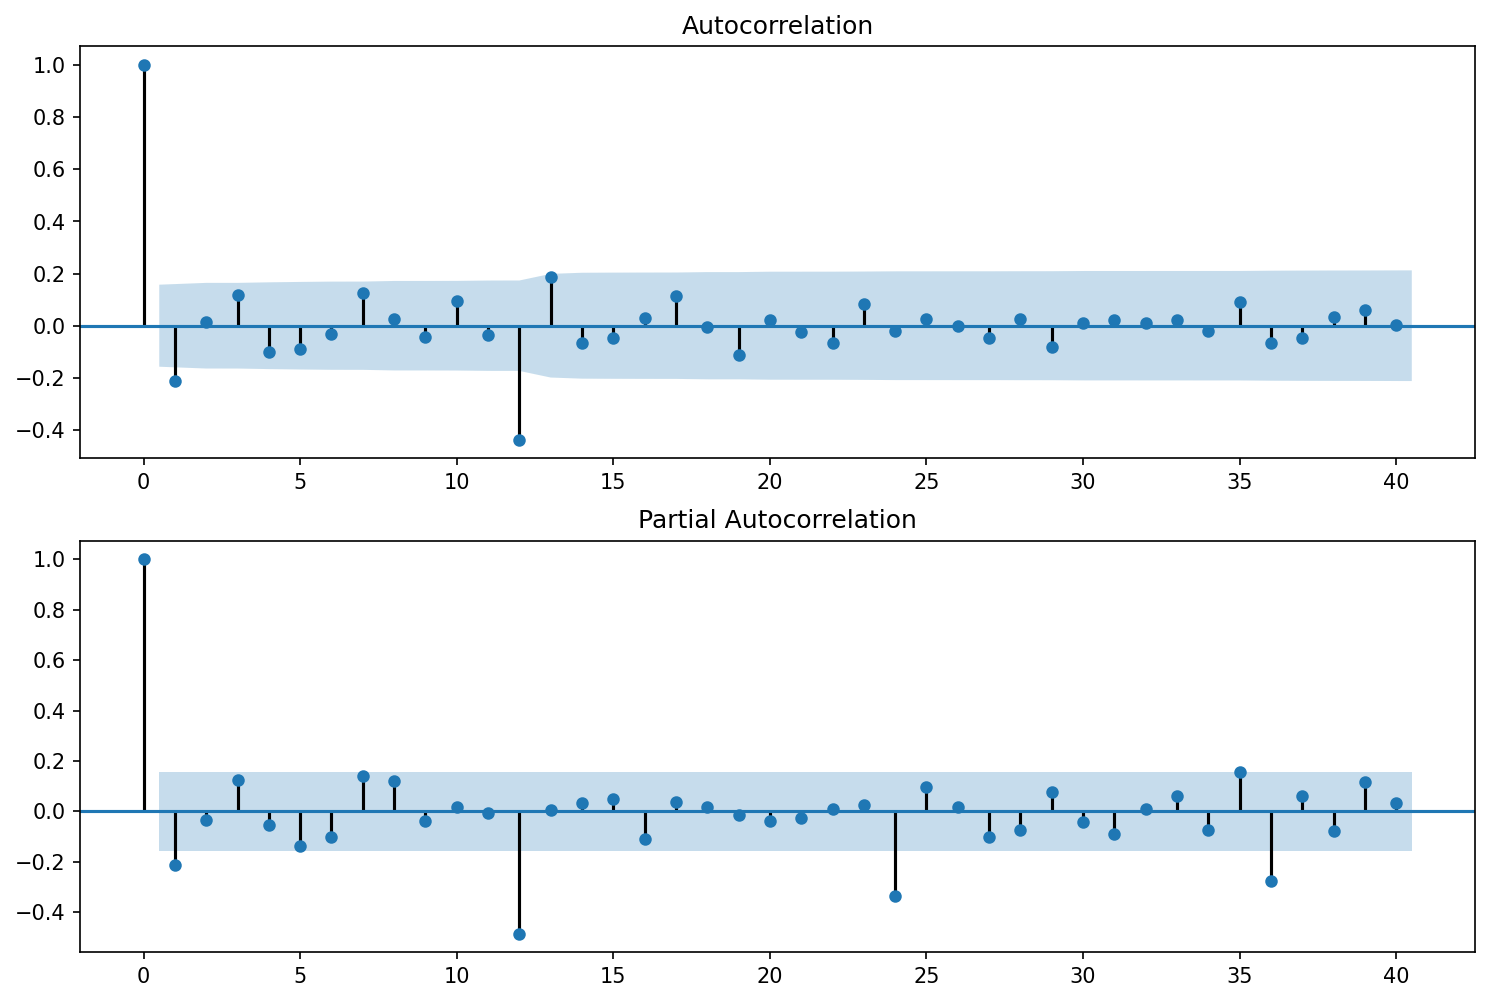

In [58]:
fig = plt.figure(figsize=(12, 8), dpi=150)
ax1 = fig.add_subplot(211)
fig = plot_acf(trend_seasonality_removed, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(trend_seasonality_removed, lags=40, ax=ax2)

In [62]:
from statsmodels.tsa.statespace import sarimax

In [64]:
model = sm.tsa.statespace.SARIMAX(df['Milk_produced'],order = (0,1,1),seasonal_order = (0,1,1,12),)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [66]:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                      Milk_produced   No. Observations:                  168
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -530.148
Date:                            Tue, 22 Feb 2022   AIC                           1066.296
Time:                                    12:38:12   BIC                           1075.427
Sample:                                01-01-1962   HQIC                          1070.005
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2204      0.076     -2.898      0.004      -0.369      -0.071
ma.S.L12      -0.6214      0.070     -8.872      0.000      -0.759      -0.484
sigma2        52.7040      4.966     10.613      0.000      42.971      62.437
===================================================================================
Ljung-Box (Q):                       21.31   Jarque-Bera (JB):                33.65
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.74
Prob(H) (two-sided):                  0.51   Kurtosis:                         4.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

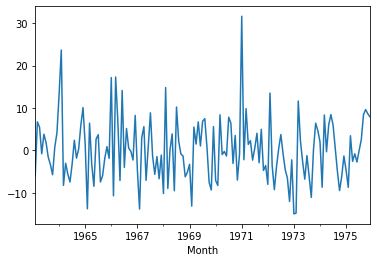

In [70]:
results.resid[13:].plot()

In [71]:
results.predict(start= 118, end = 128,dynamic = True) ### forecast the value for 118th month using the model

1971-11-01    767.727569
1971-12-01    807.257274
1972-01-01    840.484014
1972-02-01    798.180079
1972-03-01    895.751840
1972-04-01    914.221044
1972-05-01    976.988092
1972-06-01    949.721050
1972-07-01    905.068746
1972-08-01    867.628531
1972-09-01    825.988757
Freq: MS, dtype: float64

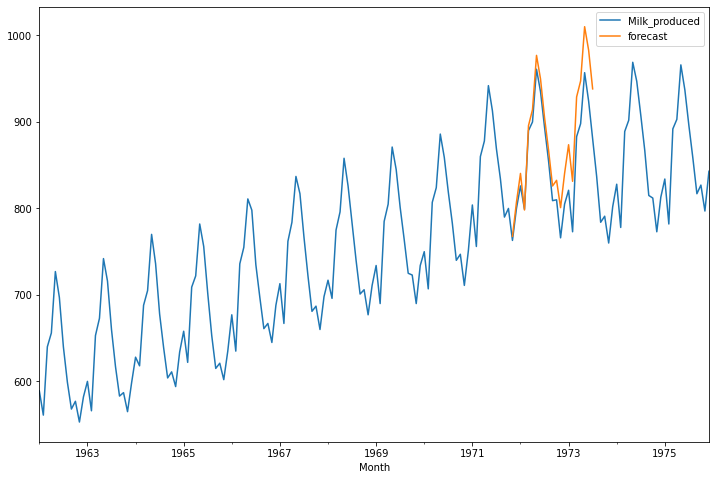

In [72]:
df['forecast'] = results.predict(start= 118, end = 138,dynamic = True)  
df[['Milk_produced','forecast']].plot(figsize = (12, 8))

In [73]:
df.shape

(168, 2)

In [74]:
results.predict(start= 168, end = 180,dynamic = True)

1976-01-01     864.977273
1976-02-01     817.749359
1976-03-01     924.405590
1976-04-01     937.483635
1976-05-01    1000.623488
1976-06-01     973.216471
1976-07-01     931.850088
1976-08-01     892.259738
1976-09-01     846.367874
1976-10-01     851.532575
1976-11-01     817.493091
1976-12-01     859.753316
1977-01-01     882.814946
Freq: MS, dtype: float64

In [75]:
from pandas.tseries.offsets import DateOffset

In [76]:
future_dates = [df.index[-1] + DateOffset(months = x) for x in range(0,14)]

In [77]:
future_dates

[Timestamp('1975-12-01 00:00:00'),
 Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00')]

In [78]:
future_dates_df = pd.DataFrame(index = future_dates[1:],columns = df.columns)

In [79]:
future_df = pd.concat([df,future_dates_df])

In [80]:
future_df.tail()

,Milk_produced,forecast
1976-09-01,NaN,NaN
1976-10-01,NaN,NaN
1976-11-01,NaN,NaN
1976-12-01,NaN,NaN
1977-01-01,NaN,NaN


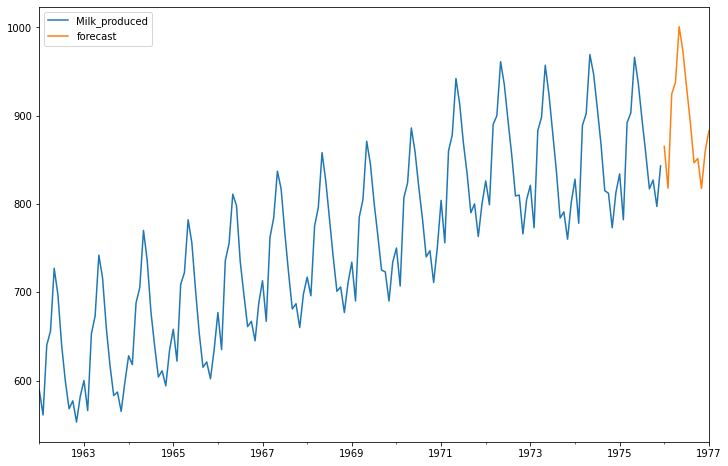

In [82]:
future_df['forecast'] = results.predict(start = 168, end = 180,dynamic= True)  
future_df[['Milk_produced', 'forecast']].plot(figsize = (12, 8)) 